# Reporting

Reporting plays a crucial role in building scorecard models.

Skorecard bucketers include a reporting module, and this tutorial shows how to extract it

In [1]:
%matplotlib inline
from skorecard.datasets import load_uci_credit_card

X, y = load_uci_credit_card(return_X_y=True)
X.head(4)

,EDUCATION,MARRIAGE,LIMIT_BAL,BILL_AMT1
0,1,2,400000.0,201800.0
1,2,2,80000.0,80610.0
2,1,2,500000.0,499452.0
3,1,1,140000.0,450.0


# Reporting in bucketers

Once a bucketer is fitted, the reporting module is incorporated directly in the bucketer object

In [2]:
from skorecard.bucketers import DecisionTreeBucketer

bucketer = DecisionTreeBucketer(max_n_bins=10)
X_transformed = bucketer.fit_transform(X, y)
X_transformed.head(4)

,EDUCATION,MARRIAGE,LIMIT_BAL,BILL_AMT1
0,0,1,9,9
1,1,1,3,7
2,0,1,9,9
3,0,0,5,0


Retrieve the bucket summary table

In [3]:
bucketer.bucket_table(column="LIMIT_BAL")

,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
1,0,"[-inf, 45000.0)",849.0,14.15,533.0,316.0,0.372203,-0.719,0.087
2,1,"[45000.0, 55000.0)",676.0,11.27,518.0,158.0,0.233728,-0.054,0.000
3,2,"[55000.0, 75000.0)",336.0,5.60,233.0,103.0,0.306548,-0.425,0.011
4,3,"[75000.0, 85000.0)",319.0,5.32,243.0,76.0,0.238245,-0.079,0.000
5,4,"[85000.0, 105000.0)",330.0,5.50,241.0,89.0,0.269697,-0.245,0.004
6,5,"[105000.0, 145000.0)",566.0,9.43,436.0,130.0,0.229682,-0.031,0.000
7,6,"[145000.0, 275000.0)",1719.0,28.65,1429.0,290.0,0.168703,0.353,0.032
8,7,"[275000.0, 325000.0)",379.0,6.32,326.0,53.0,0.139842,0.575,0.018
9,8,"[325000.0, 385000.0)",350.0,5.83,287.0,63.0,0.180000,0.275,0.004


Plotting the buckets

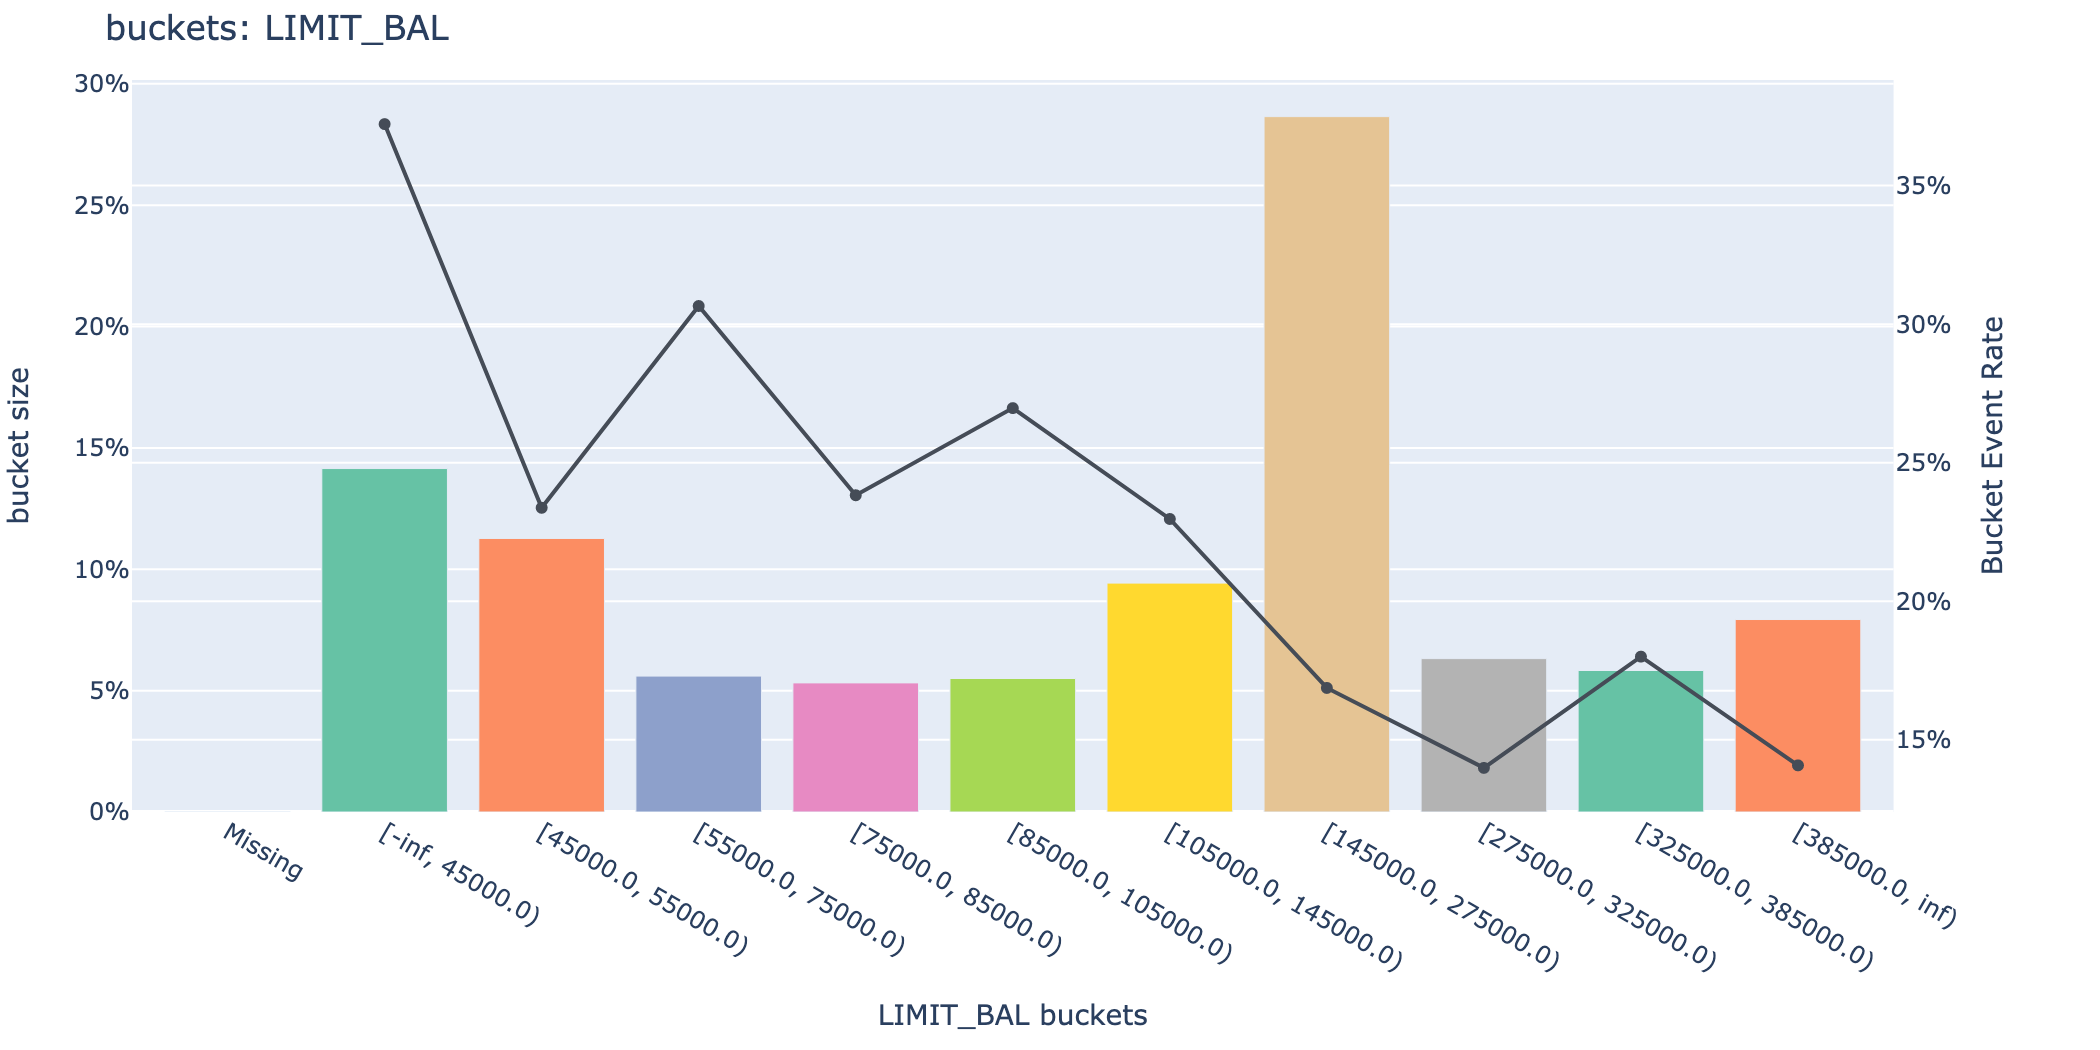

In [4]:
bucketer.plot_bucket(column="LIMIT_BAL", format="png", scale=2, width=1050, height=525)

# Statistical Significance

You will often want to report and analyse the statistical significance of the coefficients generated by the Logistic Regression Model. We do this by calculating the `p-values` of the coefficients. Typically, any coefficient with `p-value > 0.05` is regarded as *insignificant*, and hence should not be reported as a contributing feature.

Below, we show an example of how to get the summary statistics including the `p-values` using the `.get_stats()` function. As can be seen from the resulting dataframe, there are 2 features - EDUCATION and BILL_AMT1 - with "unreliable" `p-values`. 

The coefficients can be further analysed using the `weight_plot()` function. The 2-sigma confidence interval is plotted. Assuming a Gaussian distribution, 95% of data exists within this spread. The plot corroboartes the `p-values`: we can see that there is a significant chance the coefficients of EDUCATION and BILL_AMT1 are 0.

In [5]:
from skorecard.datasets import load_uci_credit_card
from skorecard.bucketers import EqualFrequencyBucketer
from skorecard.linear_model import LogisticRegression
from skorecard.reporting import weight_plot
from sklearn.pipeline import Pipeline

X, y = load_uci_credit_card(return_X_y=True)
pipeline = Pipeline(
    [("bucketer", EqualFrequencyBucketer(n_bins=10)), ("clf", LogisticRegression(calculate_stats=True))]
)
pipeline.fit(X, y)
stats = pipeline.named_steps["clf"].get_stats()

stats

/Users/iv58uq/Documents/open_source/skorecard/skorecard/bucketers/bucketers.py:502: ApproximationWarning:

Approximated quantiles - too many unique values

/Users/iv58uq/Documents/open_source/skorecard/skorecard/bucketers/bucketers.py:502: ApproximationWarning:

Approximated quantiles - too many unique values



,Coef.,Std.Err,z,P>|z|
const,-0.537571,0.096108,-5.593394,2.226735e-08
EDUCATION,0.010091,0.044874,0.224876,8.220757e-01
MARRIAGE,-0.255608,0.062513,-4.088864,4.334903e-05
LIMIT_BAL,-0.136681,0.011587,-11.796145,4.086051e-32
BILL_AMT1,-0.006634,0.011454,-0.579160,5.624809e-01


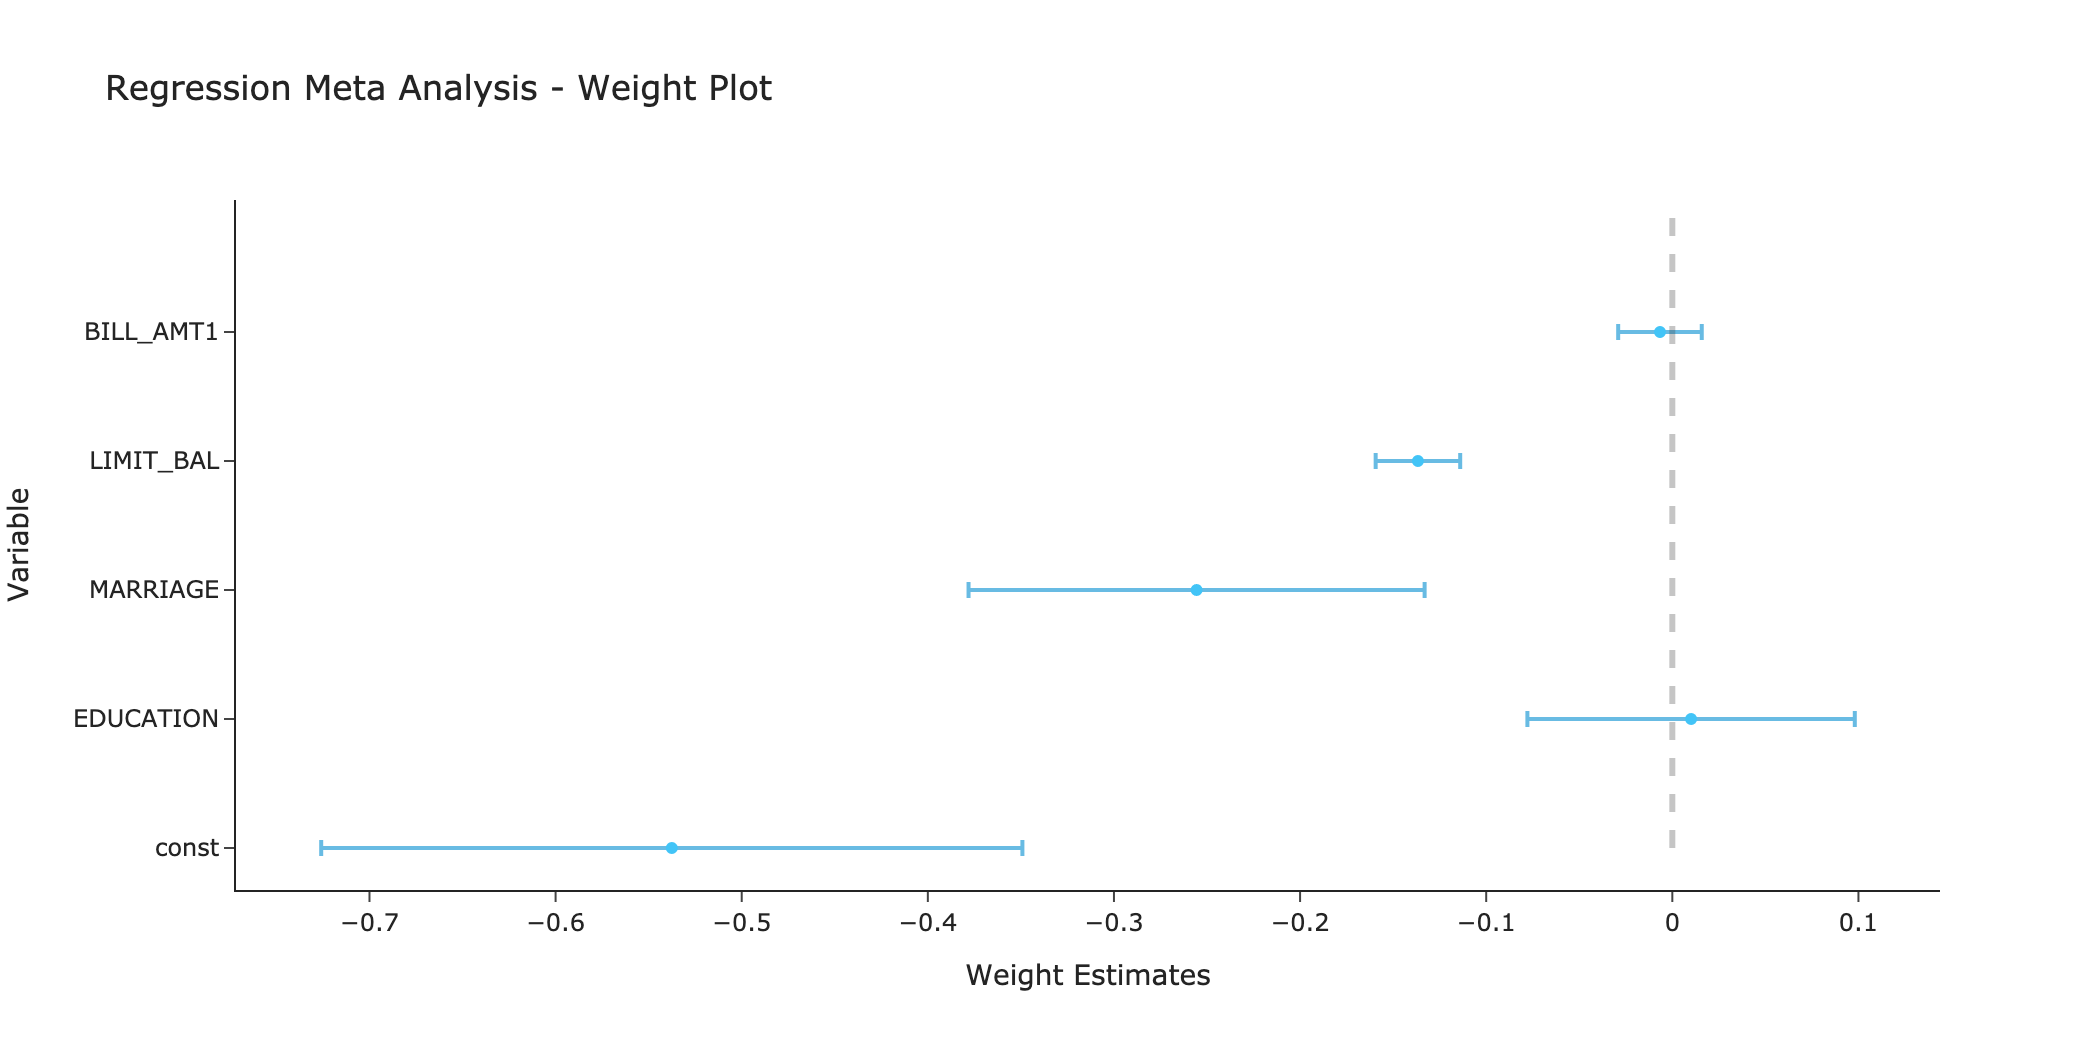

In [6]:
weight_plot(stats, format="png", scale=2, width=1050, height=525)

# Reporting in Bucketing Process

The Bucketing Process module incorporates two bucketing steps:
- the prebucketing step
- bucketing step

Let's first fit a bucketing process step

In [7]:
from skorecard import datasets
from skorecard.bucketers import DecisionTreeBucketer, OptimalBucketer, AsIsCategoricalBucketer
from skorecard.pipeline import BucketingProcess
from sklearn.pipeline import make_pipeline

df = datasets.load_uci_credit_card(as_frame=True)
y = df["default"]
X = df.drop(columns=["default"])

num_cols = ["LIMIT_BAL", "BILL_AMT1"]
cat_cols = ["EDUCATION", "MARRIAGE"]

bucketing_process = BucketingProcess(
    prebucketing_pipeline=make_pipeline(
        DecisionTreeBucketer(variables=num_cols, max_n_bins=100, min_bin_size=0.05),
        AsIsCategoricalBucketer(variables=cat_cols),
    ),
    bucketing_pipeline=make_pipeline(
        OptimalBucketer(variables=num_cols, max_n_bins=10, min_bin_size=0.05),
        OptimalBucketer(variables=cat_cols, variables_type="categorical", max_n_bins=10, min_bin_size=0.05),
    ),
)

_ = bucketing_process.fit(X, y)

## Prebucketing step

Retrieve the bucketing report of the prebucketing step by calling the `prebucket_table`.

In addition to the statstics, the prebucket_table returns also the recommended bucket for the merging.

In [8]:
bucketing_process.prebucket_table("LIMIT_BAL")

,pre-bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV,bucket
0,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000,-1
1,0,"[-inf, 25000.0)",479.0,7.98,300.0,179.0,0.373695,-0.725,0.050,0
2,1,"[25000.0, 45000.0)",370.0,6.17,233.0,137.0,0.370270,-0.710,0.037,1
3,2,"[45000.0, 55000.0)",676.0,11.27,518.0,158.0,0.233728,-0.054,0.000,2
4,3,"[55000.0, 75000.0)",336.0,5.60,233.0,103.0,0.306548,-0.425,0.011,2
5,4,"[75000.0, 85000.0)",319.0,5.32,243.0,76.0,0.238245,-0.079,0.000,3
6,5,"[85000.0, 105000.0)",330.0,5.50,241.0,89.0,0.269697,-0.245,0.004,3
7,6,"[105000.0, 145000.0)",566.0,9.43,436.0,130.0,0.229682,-0.031,0.000,4
8,7,"[145000.0, 175000.0)",449.0,7.48,380.0,69.0,0.153675,0.464,0.014,5
9,8,"[175000.0, 225000.0)",769.0,12.82,630.0,139.0,0.180754,0.270,0.009,5


Visualizing the bucketing

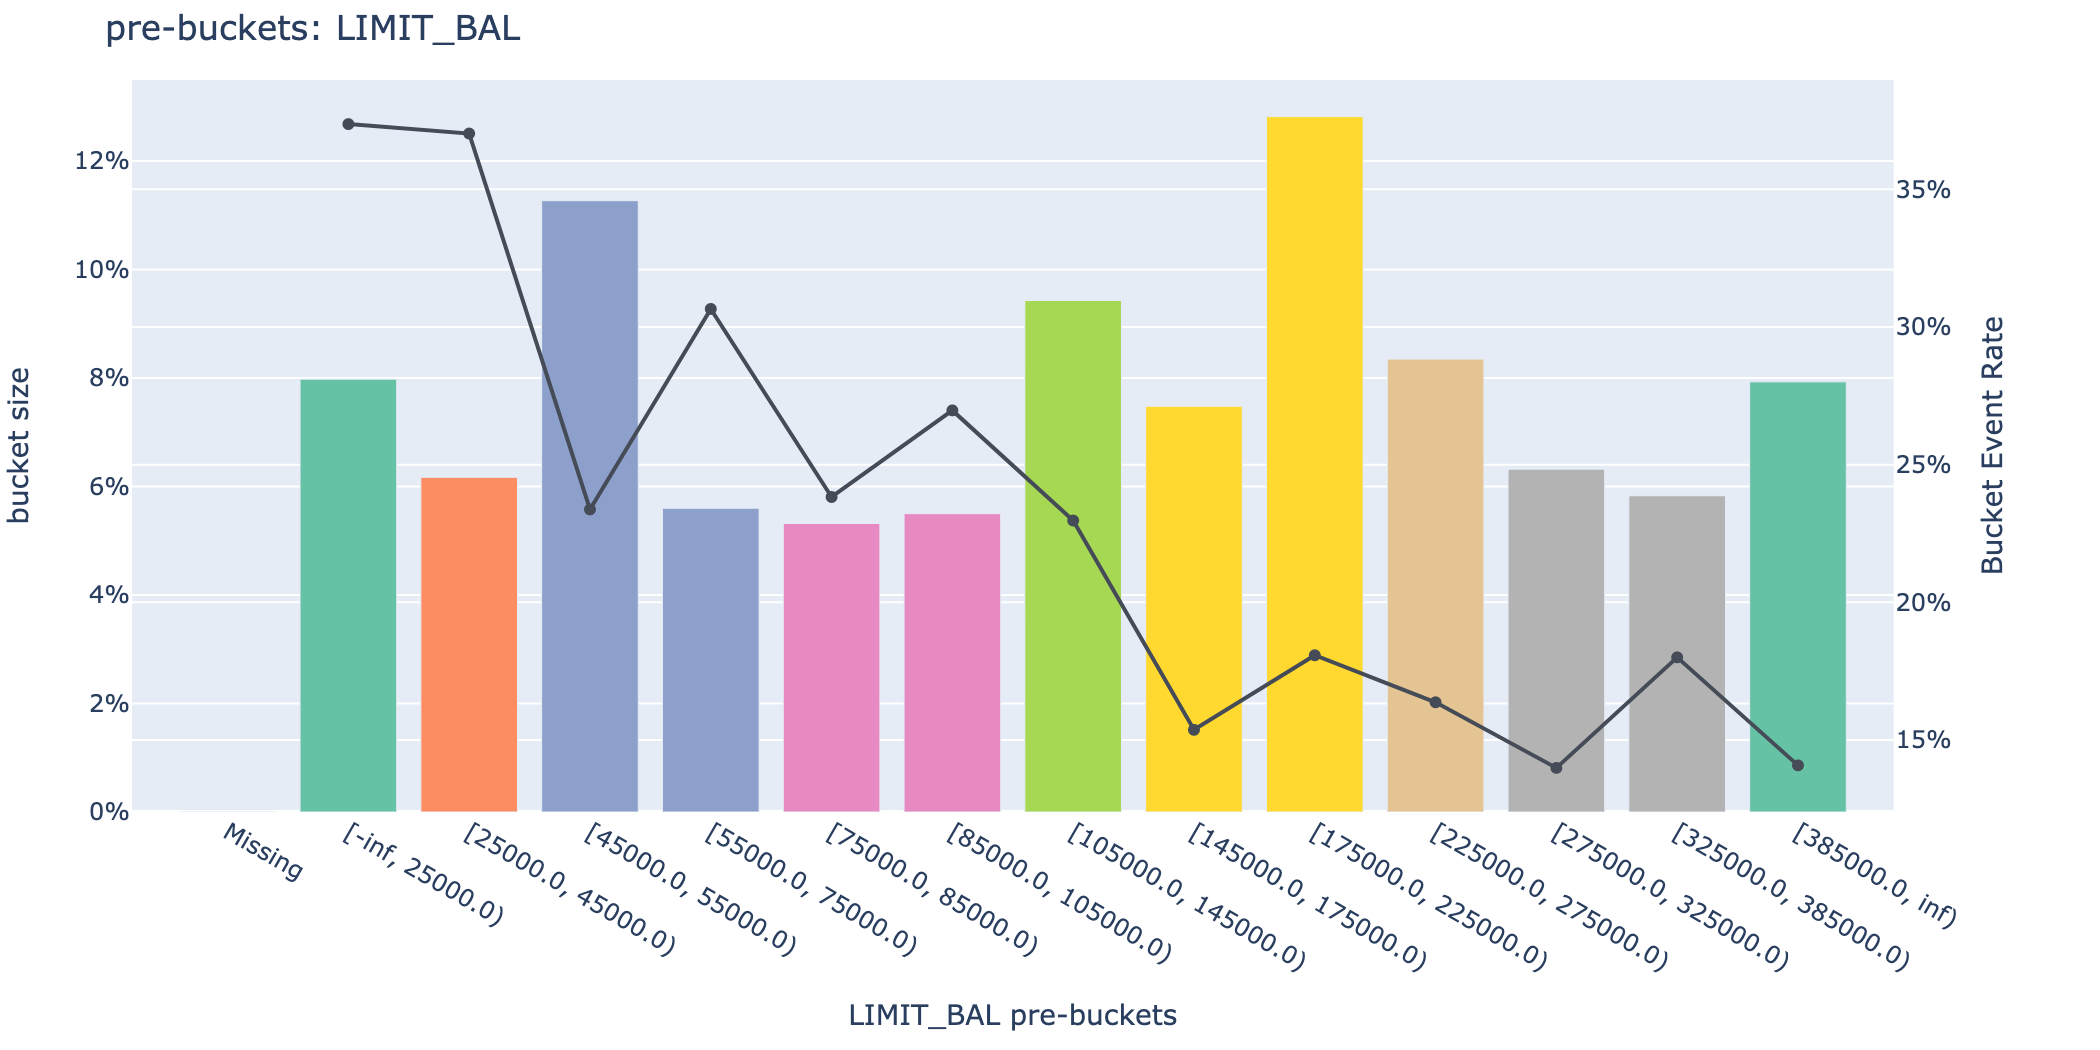

In [9]:
bucketing_process.plot_prebucket("LIMIT_BAL", format="png", scale=2, width=1050, height=525)

## Bucketing step



Retreving the bucketing table from the second step is the same like in every bucketer, ie

In [10]:
bucketing_process.bucket_table("LIMIT_BAL")

,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
1,0,"[-inf, 1.0)",479.0,7.98,300.0,179.0,0.373695,-0.725,0.050
2,1,"[1.0, 2.0)",370.0,6.17,233.0,137.0,0.370270,-0.710,0.037
3,2,"[2.0, 4.0)",1012.0,16.87,751.0,261.0,0.257905,-0.185,0.006
4,3,"[4.0, 6.0)",649.0,10.82,484.0,165.0,0.254237,-0.165,0.003
5,4,"[6.0, 7.0)",566.0,9.43,436.0,130.0,0.229682,-0.031,0.000
6,5,"[7.0, 9.0)",1218.0,20.30,1010.0,208.0,0.170772,0.339,0.021
7,6,"[9.0, 10.0)",501.0,8.35,419.0,82.0,0.163673,0.390,0.011
8,7,"[10.0, 12.0)",729.0,12.15,613.0,116.0,0.159122,0.423,0.019
9,8,"[12.0, inf)",476.0,7.93,409.0,67.0,0.140756,0.567,0.022


and the same applies to plotting the bucketing step

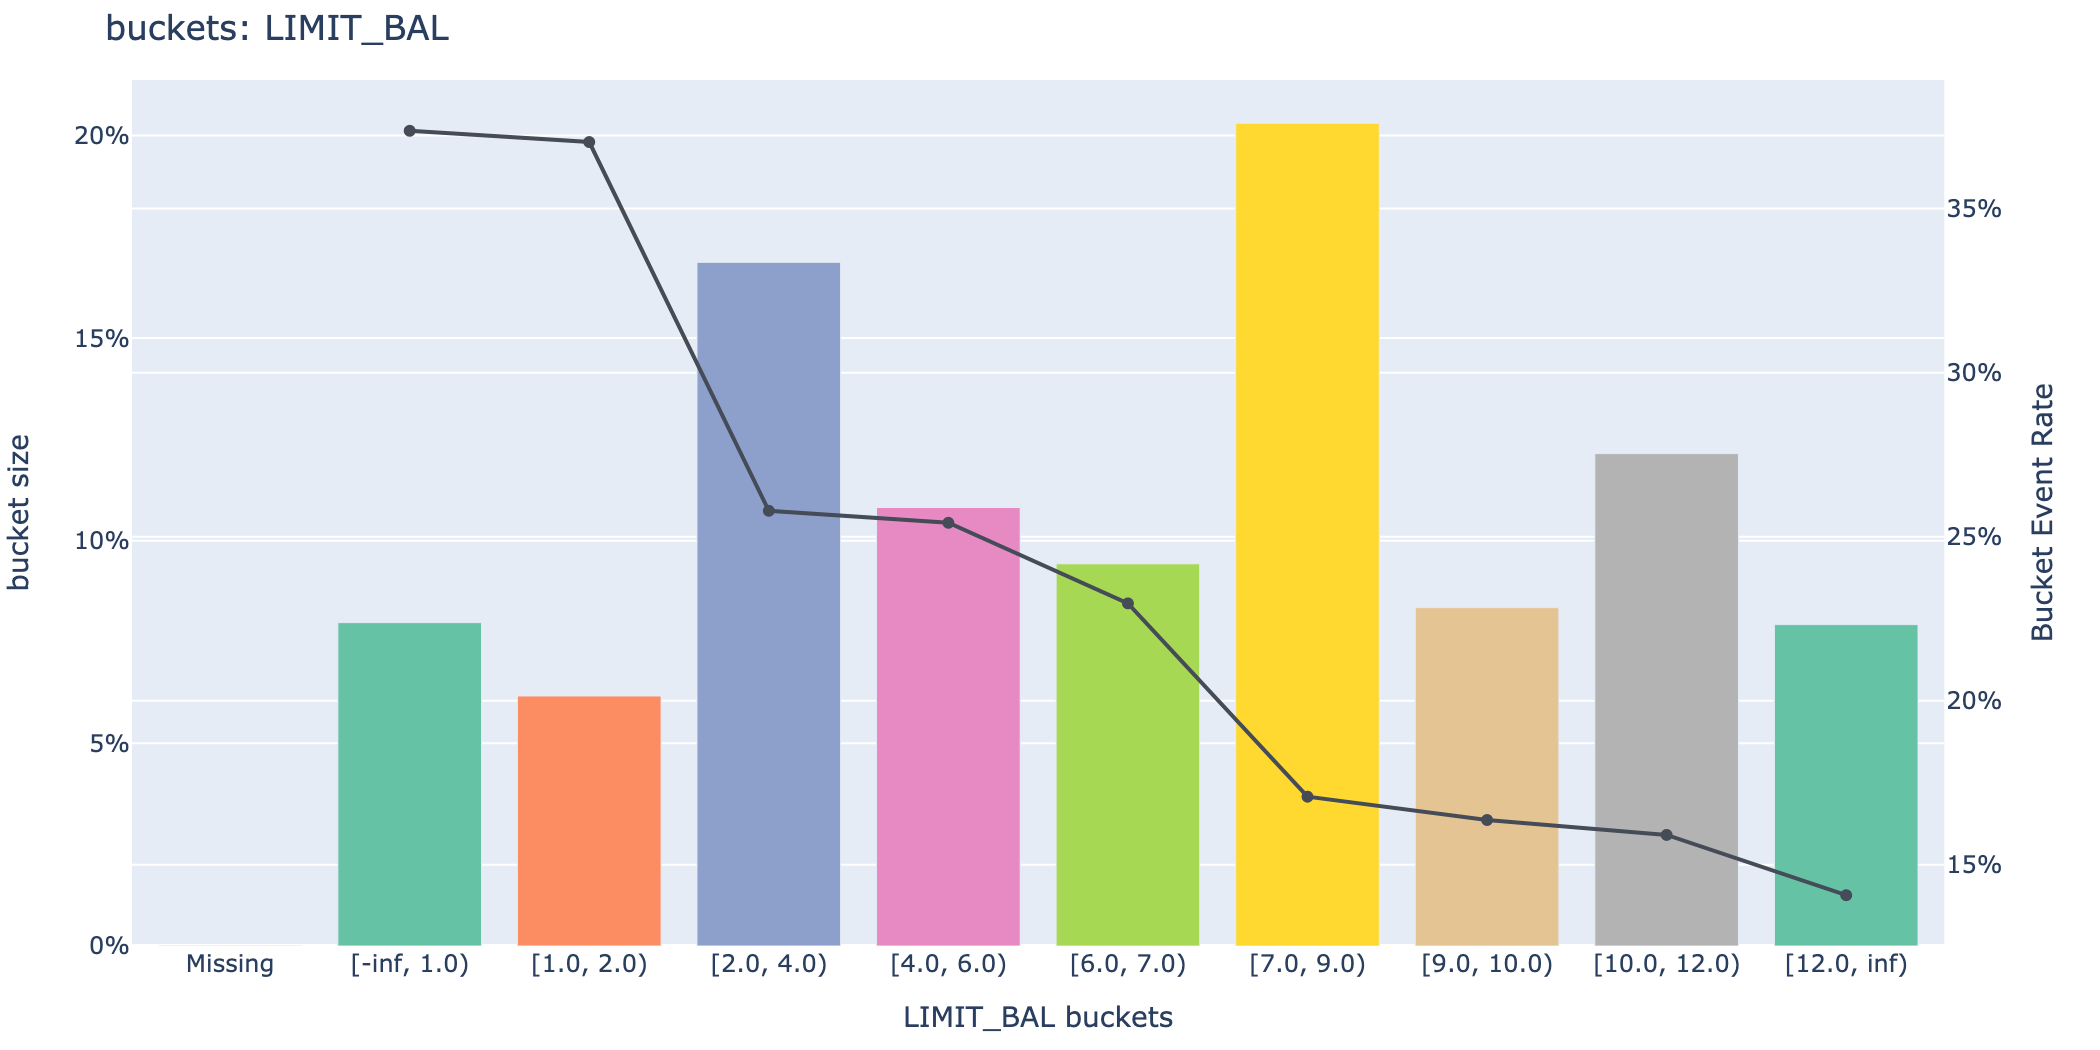

In [11]:
bucketing_process.plot_bucket("LIMIT_BAL", format="png", scale=2, width=1050, height=525)